# Machine learning model (_test notebook_)

In [53]:
%matplotlib inline

# Reading files
import h5py
import toml

# Scientific computing
import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context('paper')

# Other
import os
import requests

In [54]:
first_cycle = True
with pd.HDFStore('../classification/ris/OUT-classified-merged.h5', mode='r') as in_data:
    for group in ['GLITCH', 'NO_GLITCH']:
        if first_cycle == True:
            data = np.array(in_data[group].to_numpy())
            if group == 'GLITCH':
                target = np.ones(len(data))
            elif group == 'NO_GLITCH':
                target = np.zeros(len(data))
            else:
                print("ERROR.")
            first_cycle = False
        else:
            data = np.concatenate((data, in_data[group].to_numpy()))
            if group == 'GLITCH':
                target = np.concatenate((target, np.ones(len(in_data[group].to_numpy()))))
            elif group == 'NO_GLITCH':
                target = np.concatenate((target, np.zeros(len(in_data[group].to_numpy()))))
            else:
                print("ERROR.")
    data = np.concatenate((data, in_data['MULTI_GLITCH'].to_numpy()))
    target = np.concatenate((target, np.ones(len(in_data['MULTI_GLITCH'].to_numpy()))*2))

### Telegram post request snippet
```python
telegram_bot_id = toml.load('telegram_bot_id.toml')
params = {'chat_id': telegram_bot_id['chat_id'], 'text': 'insert text'}
requests.post('https://api.telegram.org/' + telegram_bot_id['bot_id'] + '/sendMessage', params=params)
```

## Random Forest

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)
clf = RandomForestClassifier(n_estimators=800, max_depth=400, n_jobs=-1).fit(X_train, y_train)
clf.score(X_test, y_test)

C:\Users\paolo\Miniconda3\envs\idp\lib\site-packages\daal4py\sklearn\svm\svm.py:321: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9750479846449136

In [183]:
target

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

print(__doc__)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': range(750, 850, 20),
                    'max_depth': range(350, 450, 20),
                    'min_samples_split': range(2, 8, 2),
                    'max_features': ['auto', 'log2']}

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score, n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from sklearn.preprocessing import normalize
Xproj = pca.fit_transform(normalize(data))


array([[0.01017281, 0.00084158, 0.0043304 , ..., 0.00097589, 0.00433514,
        0.00096092],
       [0.00084158, 0.01003701, 0.0008431 , ..., 0.00426488, 0.00083689,
        0.0043336 ],
       [0.0043304 , 0.0008431 , 0.0099994 , ..., 0.00097456, 0.00424922,
        0.0009602 ],
       ...,
       [0.00097589, 0.00426488, 0.00097456, ..., 0.01000687, 0.00096857,
        0.00431959],
       [0.00433514, 0.00083689, 0.00424922, ..., 0.00096857, 0.01000864,
        0.00095407],
       [0.00096092, 0.0043336 , 0.0009602 , ..., 0.00431959, 0.00095407,
        0.0101432 ]])

(0.99, 1.001)

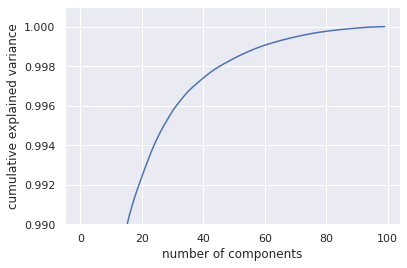

In [52]:
pca = PCA().fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.ylim(0.99,1.001)

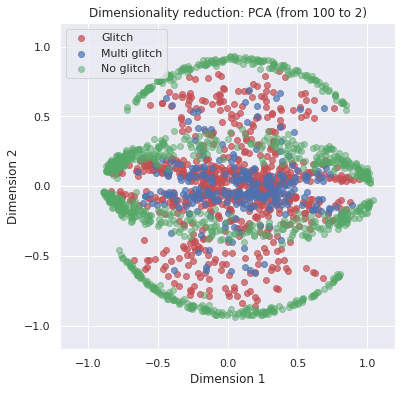

In [55]:
x_mg = Xproj[target == 2]
x_g = Xproj[target == 1]
x_ng = Xproj[target == 0]

plt.figure(figsize=(6,6))
plt.scatter(x_g[:,0], x_g[:,1], color='r', alpha=0.7, label='Glitch')
plt.scatter(x_mg[:,0], x_mg[:,1], color='b', alpha=0.7, label='Multi glitch')
plt.scatter(x_ng[:,0], x_ng[:,1], alpha=0.5, color='g', label='No glitch')
plt.legend()
plt.axis('equal')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.title('Dimensionality reduction: PCA (from 100 to 2)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.savefig('SVC/ris/plots/PCA-2_dimensions.pdf')

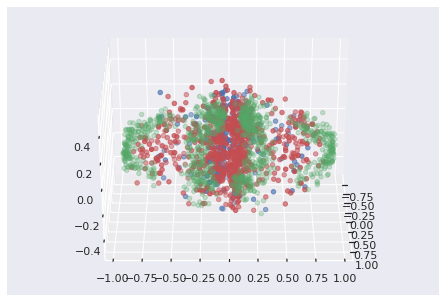

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
from IPython.display import display, clear_output
import time
fig = plt.figure()
ax = Axes3D(fig) #<-- Note the difference from your original code...

x_mg = Xproj[target == 2]
x_g = Xproj[target == 1]
x_ng = Xproj[target == 0]

ax.scatter3D(x_g[:,0], x_g[:,1], x_g[:,2], color='r')
ax.scatter3D(x_mg[:,0], x_mg[:,1], x_mg[:,2], color='b')
ax.scatter3D(x_ng[:,0], x_ng[:,1], x_ng[:,2], alpha=0.3, color='g')

ax.view_init(30, 0)

In [11]:
Xproj.shape

(2000, 2)

## SVM

In [199]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)
clf = SVC(kernel='rbf', gamma=0.0140, C=0.795).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9865642994241842

In [177]:
clf = SVC()
parameters = {'gamma': np.arange(0.01,0.02,0.0005), 'C': np.arange(0.6,1,0.005) }
GSCV = GridSearchCV(clf, parameters, n_jobs=-1, cv=11, iid=False)
GSCV.fit(data, target)

GridSearchCV(cv=11, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'gamma': array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195]), 'C': array([0.6  , 0.605, ..., 0.99 , 0.995])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [178]:
print("Best parameters set found on development set:")
print()
print(GSCV.best_params_)
print()
print("Grid scores on development set:")
print()
means = GSCV.cv_results_['mean_test_score']
stds = GSCV.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GSCV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Best parameters set found on development set:

{'C': 0.7950000000000002, 'gamma': 0.014000000000000004}

Grid scores on development set:

0.976 (+/-0.026) for {'C': 0.6, 'gamma': 0.01}
0.977 (+/-0.027) for {'C': 0.6, 'gamma': 0.0105}
0.977 (+/-0.028) for {'C': 0.6, 'gamma': 0.011000000000000001}
0.978 (+/-0.024) for {'C': 0.6, 'gamma': 0.011500000000000002}
0.977 (+/-0.027) for {'C': 0.6, 'gamma': 0.012000000000000002}
0.978 (+/-0.027) for {'C': 0.6, 'gamma': 0.012500000000000002}
0.977 (+/-0.026) for {'C': 0.6, 'gamma': 0.013000000000000003}
0.978 (+/-0.024) for {'C': 0.6, 'gamma': 0.013500000000000003}
0.979 (+/-0.025) for {'C': 0.6, 'gamma': 0.014000000000000004}
0.979 (+/-0.025) for {'C': 0.6, 'gamma': 0.014500000000000004}
0.978 (+/-0.024) for {'C': 0.6, 'gamma': 0.015000000000000005}
0.975 (+/-0.026) for {'C': 0.6, 'gamma': 0.015500000000000005}
0.974 (+/-0.025) for {'C': 0.6, 'gamma': 0.016000000000000007}
0.972 (+/-0.023) for {'C': 0.6, 'gamma': 0.016500000000000008}
0.971 (+/-

In [179]:
telegram_bot_id = toml.load('telegram_bot_id.toml')
params = {'chat_id': telegram_bot_id['chat_id'], 'text': 'Grid search terminated.'}
requests.post('https://api.telegram.org/' + telegram_bot_id['bot_id'] + '/sendMessage', params=params)

<Response [200]>